In [31]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [32]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [33]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [34]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [35]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [36]:
params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]
evals_result = {}  # 储存评估指标(内置和自定义)结果

model = lgb.train(params=params,
                  train_set=train_dataset,
                  early_stopping_rounds=20,  # 默认early_stopping_rounds=None
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  # This dictionary used to store all evaluation results of all the items in valid_sets.
                  evals_result=evals_result,
                  num_boost_round=200,  # 默认num_boost_round=1000
                  # Requires at least one validation data.
                  # If True, the eval metric on the valid set is printed at each boosting stage.
                  # If int, the eval metric on the valid set is printed at every verbose_eval boosting stage.
                  # The last boosting stage or the boosting stage found by using early_stopping_rounds is also printed.
                  verbose_eval=200,  # 默认verbose_eval=True
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.0554566	training's MY_GBM_LOSS: 0.0554566	valid_1's multi_logloss: 0.411312	valid_1's MY_GBM_LOSS: 0.411312


array([[5.92986901e-02, 9.26708603e-01, 1.31147371e-03, ...,
        9.72300180e-03, 1.58502969e-03, 6.66611069e-04],
       [2.33178684e-02, 7.70265976e-03, 2.34873592e-04, ...,
        6.48365690e-04, 2.84926699e-04, 9.67684442e-01],
       [1.67260617e-02, 9.81179768e-01, 3.48903337e-04, ...,
        9.58088222e-04, 4.21737716e-04, 1.77459925e-04],
       ...,
       [4.24259800e-01, 1.09401834e-02, 8.71066867e-04, ...,
        2.39853390e-03, 1.05378951e-03, 5.60006836e-01],
       [1.10236364e-03, 3.10347591e-02, 1.68796465e-04, ...,
        9.22122168e-04, 9.66594721e-01, 8.60707432e-05],
       [4.66940497e-04, 8.53869075e-04, 9.90614216e-01, ...,
        6.41975441e-04, 6.71434733e-03, 1.19431388e-04]])

In [37]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 0.05545662916306393),
                          ('MY_GBM_LOSS', 0.05545662916306393)]),
             'valid_1': OrderedDict([('multi_logloss', 0.4113119020290156),
                          ('MY_GBM_LOSS', 0.4113119020290156)])})

In [38]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.340073161007923,
                1.1448015134259226,
                1.0020609860745868,
                0.8867455464529332,
                0.7921311612365926,
                0.7119279429031609,
                0.6414697154461909,
                0.5826070911880266,
                0.5313878542098774,
                0.48625907470387614,
                0.44618532234206654,
                0.41162261193437705,
                0.3808980625660265,
                0.352490860707225,
                0.3272511121499359,
                0.3043934040866834,
                0.2826615045654622,
                0.26374044926533224,
                0.24629293768118998,
                0.23048752189696978,
                0.21553159362862528,
                0.20167392918240704,
                0.18940653428760185,
                0.17801356059750087,
                0.16726226261980046,
                0.15746007602392245,
          

In [39]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

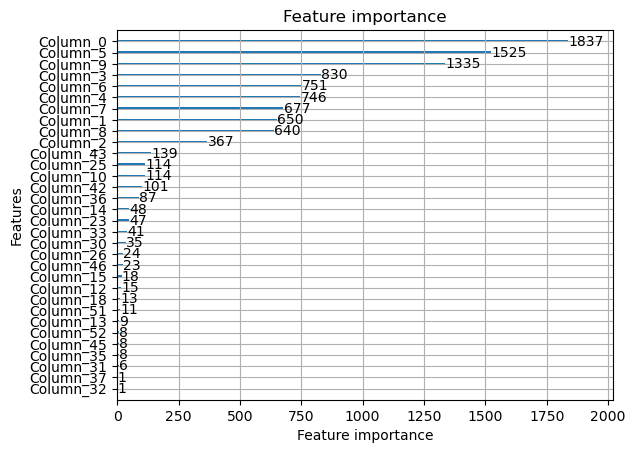

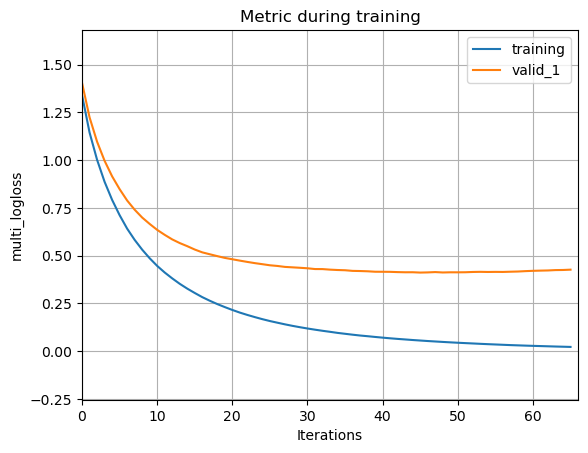

In [40]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

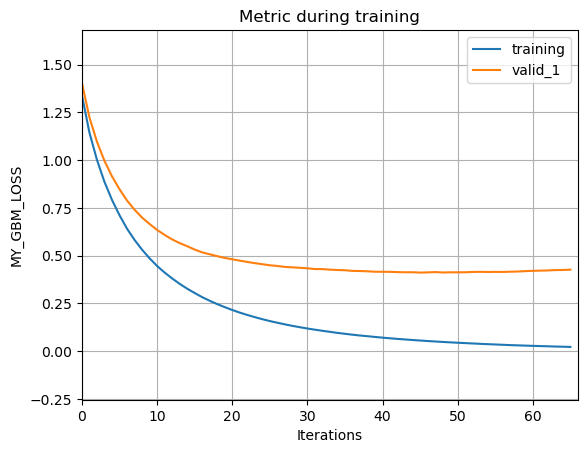

In [41]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [42]:
# 特征的相对重要性
model.feature_importance()

array([1643,  660,  380,  767,  666, 1439,  676,  605,  650, 1293,  139,
          0,   18,   42,   48,    8,    0,    0,   10,    0,    0,    0,
          0,   35,    0,  108,   31,    0,    0,    0,   17,    5,    0,
        129,    0,    1,   34,    7,    0,    0,    0,    0,   76,   81,
          5,    0,    9,    0,    0,    0,    0,    4,   14,    0])

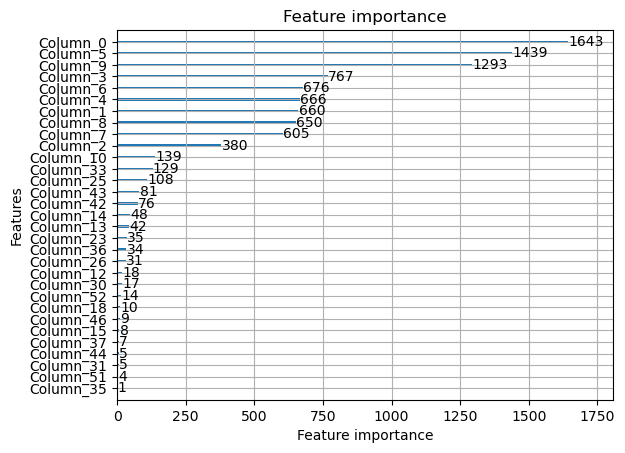

In [43]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

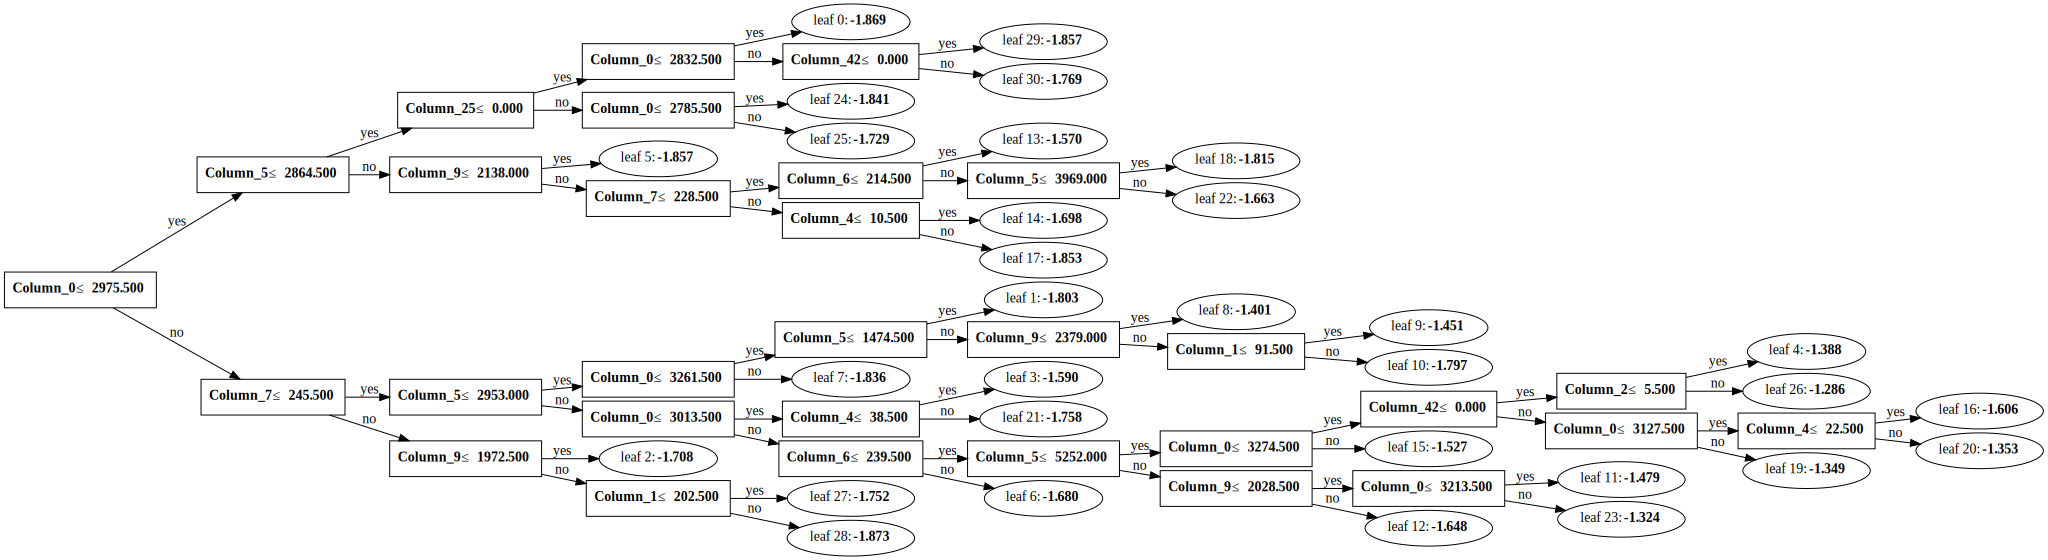

In [44]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [45]:
# 数据类型为graphviz.dot.Digraph
type(img)




graphviz.dot.Digraph